In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import std
import os

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import hvplot.pandas
import plotly.figure_factory as ff

import geopandas as gpd
from shapely.geometry import Point

import statsmodels.formula.api as sm

In [131]:
df = pd.read_csv("./ZillowData.csv")
df = df.drop(columns=['Unnamed: 0'])
df["price"] = df["price"].astype(float)
df["price_sqft"] = (df["price"]/df["sqft"]).round(2)

In [132]:
# df.dtypes

In [133]:
# Mean vs Max & Min
df['proptype'] = np.where((df['type'] == 'SINGLE_FAMILY'), 1, 0)
df.describe().round(1)

,id,price,zipcode,beds,baths,sqft,latitude,longitude,price_sqft,proptype
count,2.107000e+03,2107.0,2107.0,2107.0,2107.0,2107.0,2107.0,2107.0,2107.0,2107.0
mean,5.961737e+08,754546.4,84089.2,3.9,2.9,2694.0,40.6,-111.9,278.4,0.7
std,8.888768e+08,923773.4,34.2,1.9,2.7,2030.5,0.1,0.1,118.6,0.5
min,1.270996e+07,28000.0,84009.0,0.0,1.0,465.0,40.5,-112.1,34.6,0.0
25%,1.281799e+07,449900.0,84081.0,3.0,2.0,1684.5,40.6,-112.0,211.8,0.0
50%,5.283679e+07,569000.0,84096.0,4.0,3.0,2296.0,40.6,-111.9,254.4,1.0
75%,2.060709e+09,765000.0,84116.0,5.0,3.0,3225.5,40.7,-111.9,314.2,1.0
max,2.146808e+09,16950000.0,84129.0,54.0,112.0,58400.0,40.8,-111.6,1837.6,1.0


In [134]:
numeric_df = df.drop(columns=['id', 'address', 'city', 'state', 'url', 'broker', 'type'])
# numeric_df["price"] = numeric_df["price"]/10000
# numeric_df["$/sqft"] = numeric_df["$/sqft"]/10
# numeric_df["sqft"] = numeric_df["sqft"]/100
numeric_df

,price,zipcode,beds,baths,sqft,latitude,longitude,price_sqft,proptype
0,5500000.0,84092,6.0,5.0,6408.0,40.593044,-111.624115,858.30,1
1,4499000.0,84092,4.0,5.0,3600.0,40.586254,-111.649610,1249.72,0
2,379900.0,84065,3.0,3.0,1475.0,40.495575,-111.933880,257.56,0
3,575000.0,84065,3.0,3.0,2977.0,40.476547,-111.907740,193.15,1
4,585000.0,84065,5.0,4.0,2671.0,40.478275,-111.913345,219.02,1
...,...,...,...,...,...,...,...,...,...
2102,585000.0,84128,3.0,2.0,1966.0,40.708480,-112.036740,297.56,0
2103,689900.0,84081,5.0,3.0,4445.0,40.631500,-112.064600,155.21,1
2104,549999.0,84119,4.0,4.0,2588.0,40.698166,-111.954570,212.52,0
2105,849900.0,84119,6.0,4.0,3162.0,40.693214,-111.950030,268.79,0


## GeoSpatial Analysis

In [135]:
utah_map = gpd.read_file('Municipal_Boundaries/Municipal_Boundaries.shp')

In [136]:
crs = 'EPSG:4326'
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
geo_df = gpd.GeoDataFrame(df, crs = crs, geometry = geometry)

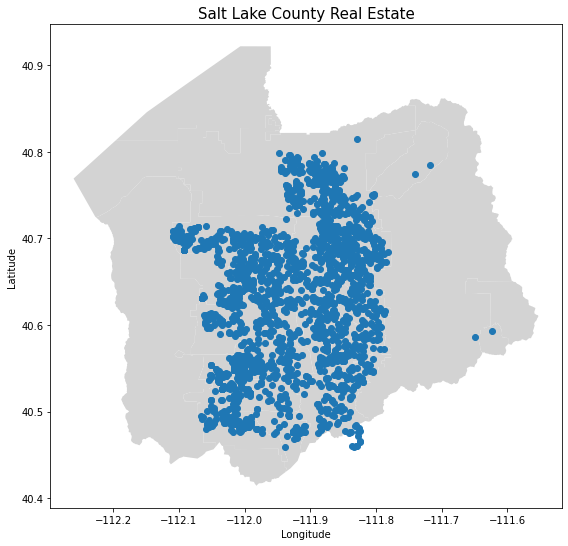

In [137]:
fig, ax = plt.subplots(figsize = (8,8))
utah_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df.plot(ax=ax)
ax.set_title('Salt Lake County Real Estate', fontsize = 15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.savefig('charts/SLC Real Estate')
plt.show()

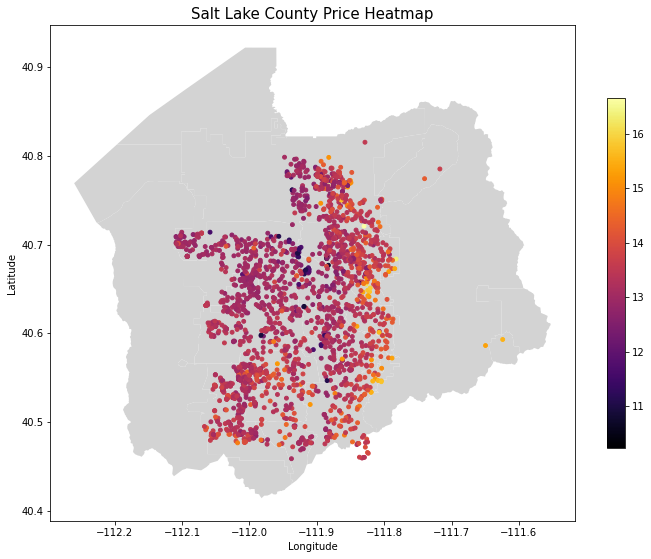

In [138]:
geo_df['price_log'] = np.log(geo_df['price'])
fig, ax = plt.subplots(figsize = (10,10))
utah_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df.plot(column = 'price_log', ax=ax, cmap = 'inferno',
            legend = True, legend_kwds={'shrink': 0.5}, markersize = 15)
ax.set_title('Salt Lake County Price Heatmap', fontsize = 15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.savefig('charts/Price Heat Map')
plt.show()

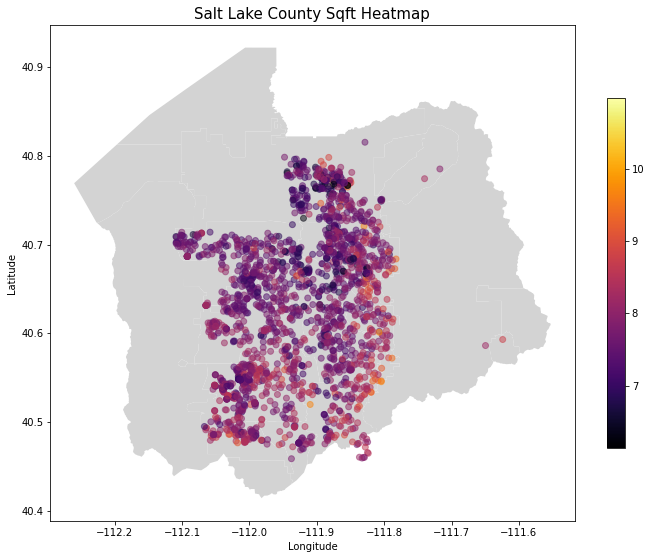

In [139]:
geo_df['sqft_log'] = np.log(geo_df['sqft'])
fig, ax = plt.subplots(figsize = (10,10))
utah_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df.plot(column = 'sqft_log', ax=ax, cmap = 'inferno',
            legend = True, legend_kwds={'shrink': 0.5},
            alpha = .5)
ax.set_title('Salt Lake County Sqft Heatmap', fontsize = 15)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.savefig('charts/Sqft Heat Map')
plt.show()

## Preliminary Analysis

In [140]:
average_price = df.groupby(["city"]).mean().round(2)["price"]
count = df.groupby(["city"]).count()["price"]
average_sqft = df.groupby(["city"]).mean().round(2)["sqft"]
cost_sqft = df.groupby(["city"]).mean().round(2)["price_sqft"]
summary = pd.DataFrame({"average_price" : average_price,
                        "count" : count,
                        "average_sqft" : average_sqft,
                        "cost_sqft" : cost_sqft})
summary = summary.reset_index()
summary = summary.sort_values(["average_price"], ascending=False)
summary

,city,average_price,count,average_sqft,cost_sqft
0,Alta,4499000.00,1,3600.00,1249.72
12,Park City,3950000.00,1,5428.00,727.71
5,Holladay,1483162.03,66,3443.12,371.62
15,Sandy,1014815.75,189,3407.12,268.82
3,Draper,992457.25,95,3805.45,269.04
2,Cottonwood Heights,973399.86,7,3278.86,295.84
14,Salt Lake City,809960.61,654,2426.45,325.20
13,Riverton,731920.57,67,3017.15,249.95
4,Herriman,729621.18,184,3215.46,232.19
16,South Jordan,714083.29,221,2909.02,264.52


### Outliers

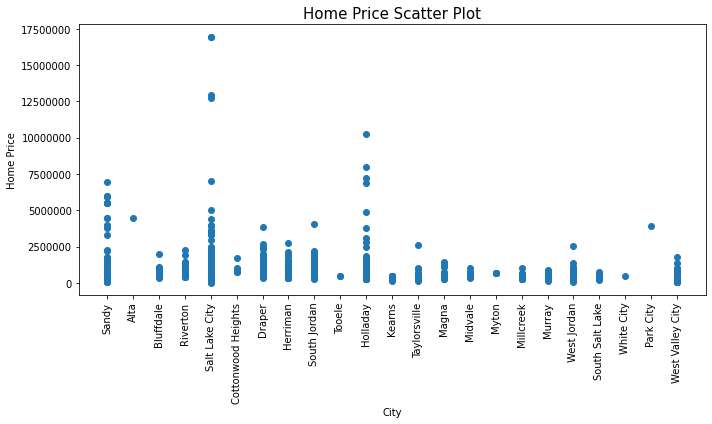

In [141]:
x_axis = np.arange(len(summary))
tick_locations = [value for value in x_axis]
plt.figure(figsize=(10,6))
plt.scatter(df["city"], df["price"])
plt.xticks(rotation='vertical')
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
plt.title("Home Price Scatter Plot", fontsize = 15)
plt.xlabel("City")
plt.ylabel("Home Price")
plt.tight_layout()
plt.savefig('charts/BC Home Price Scatter')
plt.show()

In [142]:
# # Holladay Box Plot
outlier = df.loc[df["city"] == "Holladay"]
outlier = outlier['price']
# plt.boxplot(outlier)
# plt.show()

# Remove Holladay Outliers
# Calculate interquartile range
q25, q75 = np.percentile(outlier, 25), np.percentile(outlier, 75)
iqr = q75 - q25
iqr

# Calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

# Identify outliers
outliers = [x for x in outlier if x < lower or x > upper]
# print(outliers)

# Remove outliers
df = df.drop(df[(df['city'] == 'Holladay') & (df['price'] < lower)].index)
df = df.drop(df[(df['city'] == 'Holladay') & (df['price'] > upper)].index)

# outlier = df.loc[df["city"] == "Holladay"]
# outlier = outlier['price']
# plt.boxplot(outlier)
# plt.show()

In [143]:
# # Salt Lake City Box Plot
outlier = df.loc[df["city"] == "Salt Lake City"]
outlier = outlier['price']

# Remove Salt Lake City Outliers
# Calculate interquartile range
q25, q75 = np.percentile(outlier, 25), np.percentile(outlier, 75)
iqr = q75 - q25

# Calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

# Identify outliers
outliers = [x for x in outlier if x < lower or x > upper]

# Remove outliers
df = df.drop(df[(df['city'] == 'Salt Lake City') & (df['price'] < lower)].index)
df = df.drop(df[(df['city'] == 'Salt Lake City') & (df['price'] > upper)].index)

In [144]:
# # Sandy Box Plot
outlier = df.loc[df["city"] == "Sandy"]
outlier = outlier['price']

# Remove Sandy Outliers
# Calculate interquartile range
q25, q75 = np.percentile(outlier, 25), np.percentile(outlier, 75)
iqr = q75 - q25

# Calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

# Identify outliers
outliers = [x for x in outlier if x < lower or x > upper]

# Remove outliers
df = df.drop(df[(df['city'] == 'Sandy') & (df['price'] < lower)].index)
df = df.drop(df[(df['city'] == 'Sandy') & (df['price'] > upper)].index)

In [145]:
# # South Jordan Box Plot
outlier = df.loc[df["city"] == "South Jordan"]
outlier = outlier['price']

# Remove South Jordan Outliers
# Calculate interquartile range
q25, q75 = np.percentile(outlier, 25), np.percentile(outlier, 75)
iqr = q75 - q25

# Calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

# Identify outliers
outliers = [x for x in outlier if x < lower or x > upper]

# Remove outliers
df = df.drop(df[(df['city'] == 'South Jordan') & (df['price'] < lower)].index)
df = df.drop(df[(df['city'] == 'South Jordan') & (df['price'] > upper)].index)

In [146]:
# # West Jordan Box Plot
outlier = df.loc[df["city"] == "West Jordan"]
outlier = outlier['price']

# Remove West Jordan Outliers
# Calculate interquartile range
q25, q75 = np.percentile(outlier, 25), np.percentile(outlier, 75)
iqr = q75 - q25

# Calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

# Identify outliers
outliers = [x for x in outlier if x < lower or x > upper]

# Remove outliers
df = df.drop(df[(df['city'] == 'West Jordan') & (df['price'] < lower)].index)
df = df.drop(df[(df['city'] == 'West Jordan') & (df['price'] > upper)].index)

In [147]:
# # Draper Box Plot
outlier = df.loc[df["city"] == "Draper"]
outlier = outlier['price']

# Remove Draper Outliers
# Calculate interquartile range
q25, q75 = np.percentile(outlier, 25), np.percentile(outlier, 75)
iqr = q75 - q25

# Calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

# Identify outliers
outliers = [x for x in outlier if x < lower or x > upper]

# Remove outliers
df = df.drop(df[(df['city'] == 'Draper') & (df['price'] < lower)].index)
df = df.drop(df[(df['city'] == 'Draper') & (df['price'] > upper)].index)

In [148]:
# # Taylorsville Box Plot
outlier = df.loc[df["city"] == "Taylorsville"]
outlier = outlier['price']

# Remove Taylorsville Outliers
# Calculate interquartile range
q25, q75 = np.percentile(outlier, 25), np.percentile(outlier, 75)
iqr = q75 - q25

# Calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

# Identify outliers
outliers = [x for x in outlier if x < lower or x > upper]

# Remove outliers
df = df.drop(df[(df['city'] == 'Taylorsville') & (df['price'] < lower)].index)
df = df.drop(df[(df['city'] == 'Taylorsville') & (df['price'] > upper)].index)

In [149]:
# Drop cities with no data
df = df.loc[df["city"] != "White City"]
df = df.loc[df["city"] != "Myton"]
df = df.loc[df["city"] != "Tooele"]
df = df.loc[df["city"] != "Park City"]
df = df.loc[df["city"] != "Alta"]
df = df.loc[df["city"] != "Cottonwood Heights"]

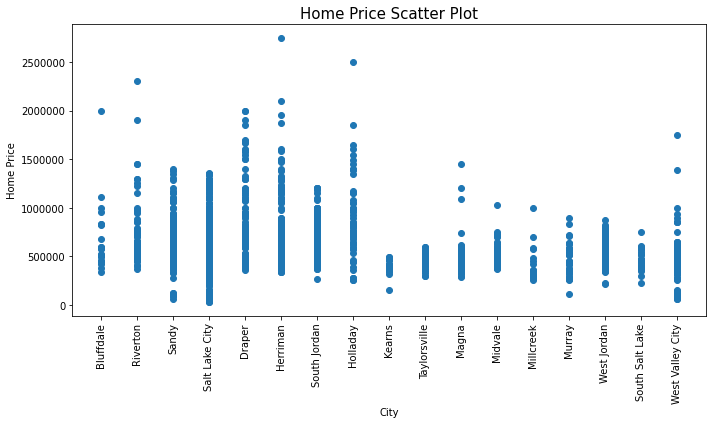

In [150]:
x_axis = np.arange(len(summary))
tick_locations = [value for value in x_axis]
plt.figure(figsize=(10,6))
plt.scatter(df["city"], df["price"])
plt.xticks(rotation='vertical')
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
plt.title("Home Price Scatter Plot", fontsize = 15)
plt.xlabel("City")
plt.ylabel("Home Price")
plt.tight_layout()
plt.savefig('charts/AC Home Price Scatter')
plt.show()

In [151]:
df["city"].value_counts()

Salt Lake City      597
South Jordan        208
West Jordan         189
Herriman            184
Sandy               167
West Valley City    149
Draper               91
Riverton             67
Magna                62
Holladay             58
Midvale              41
Taylorsville         40
Murray               38
South Salt Lake      25
Bluffdale            21
Kearns               19
Millcreek            16
Name: city, dtype: int64

In [152]:
average_price = df.groupby(["city"]).mean().round(2)["price"]
count = df.groupby(["city"]).count()["price"]
average_sqft = df.groupby(["city"]).mean().round(2)["sqft"]
cost_sqft = df.groupby(["city"]).mean().round(2)["price_sqft"]
summary = pd.DataFrame({"average_price" : average_price,
                        "count" : count,
                        "average_sqft" : average_sqft,
                        "cost_sqft" : cost_sqft})
summary = summary.reset_index()
summary = summary.sort_values(["average_price"], ascending=False)

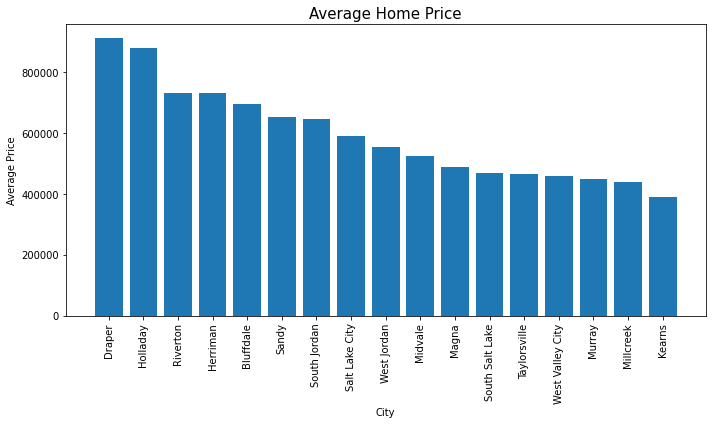

In [153]:
x_axis = np.arange(len(summary))
tick_locations = [value for value in x_axis]
plt.figure(figsize=(10,6))
plt.bar(summary["city"], summary["average_price"])
plt.xticks(tick_locations, summary["city"], rotation='vertical')
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
plt.title("Average Home Price", fontsize = 15)
plt.xlabel("City")
plt.ylabel("Average Price")
plt.tight_layout()
plt.savefig('charts/Average Home Price')
plt.show()

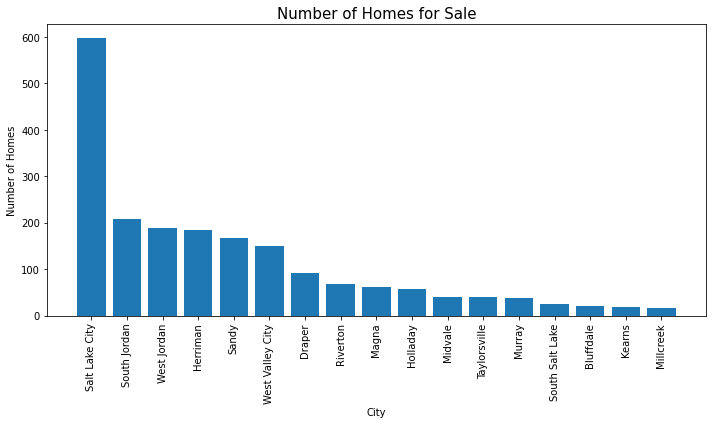

In [154]:
summary = summary.sort_values(["count"], ascending=False)

x_axis = np.arange(len(summary))
tick_locations = [value for value in x_axis]
plt.figure(figsize=(10,6))
plt.bar(summary["city"], summary["count"])
plt.xticks(tick_locations, summary["city"], rotation='vertical')
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
plt.title("Number of Homes for Sale", fontsize = 15)
plt.xlabel("City")
plt.ylabel("Number of Homes")
plt.tight_layout()
plt.savefig('charts/Number of Homes for Sale')
plt.show()

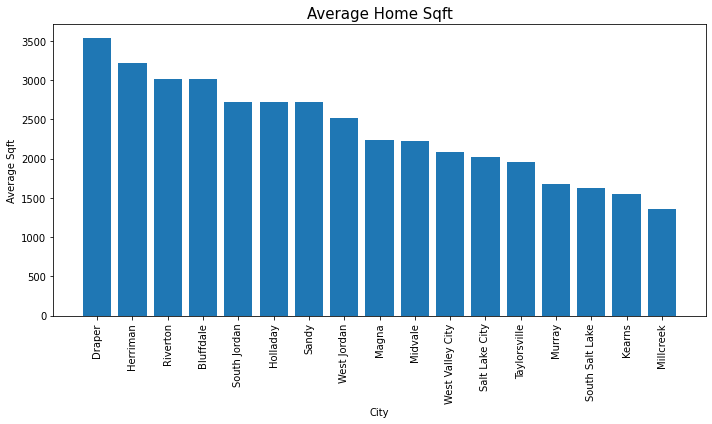

In [155]:
summary = summary.sort_values(["average_sqft"], ascending=False)

x_axis = np.arange(len(summary))
tick_locations = [value for value in x_axis]
plt.figure(figsize=(10,6))
plt.bar(summary["city"], summary["average_sqft"])
plt.xticks(tick_locations, summary["city"], rotation='vertical')
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
plt.title("Average Home Sqft", fontsize = 15)
plt.xlabel("City")
plt.ylabel("Average Sqft")
plt.tight_layout()
plt.savefig('charts/Average Home Sqft')
plt.show()

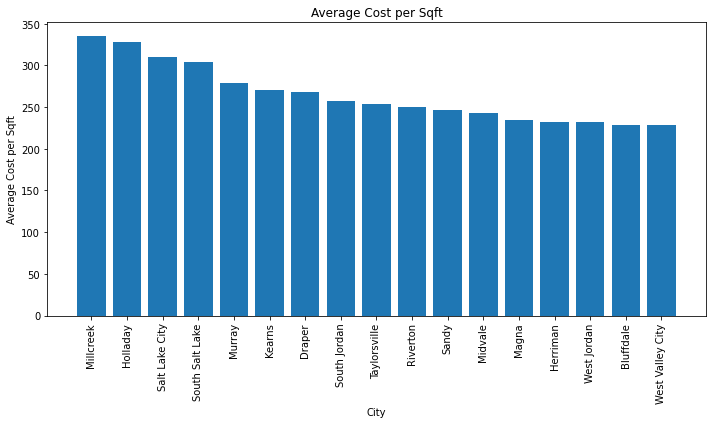

In [156]:
summary = summary.sort_values(["cost_sqft"], ascending=False)

x_axis = np.arange(len(summary))
tick_locations = [value for value in x_axis]
plt.figure(figsize=(10,6))
plt.bar(summary["city"], summary["cost_sqft"])
plt.xticks(tick_locations, summary["city"], rotation='vertical')
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
plt.title("Average Cost per Sqft")
plt.xlabel("City")
plt.ylabel("Average Cost per Sqft")
plt.tight_layout()
plt.savefig('charts/Average Cost per Sqft')
plt.show()

In [157]:
average_price = df.groupby(["zipcode"]).mean().round(2)["price"]
count = df.groupby(["zipcode"]).count()["price"]
average_sqft = df.groupby(["zipcode"]).mean().round(2)["sqft"]
cost_sqft = df.groupby(["zipcode"]).mean().round(2)["price_sqft"]
summary = pd.DataFrame({"average_price" : average_price,
                        "count" : count,
                        "average_sqft" : average_sqft,
                        "cost_sqft" : cost_sqft})
summary = summary.reset_index()
summary = summary.sort_values(["average_price"], ascending=False)
summary

,zipcode,average_price,count,average_sqft,cost_sqft
1,84020,911048.78,91,3533.37,267.84
9,84092,808191.18,51,3565.67,232.87
30,84121,796197.69,48,2889.35,289.23
18,84105,782877.74,27,2400.26,332.07
10,84093,772603.04,27,2832.15,281.23
21,84108,764839.50,24,2194.54,367.20
26,84117,755798.23,61,2411.48,324.82
12,84095,752398.24,58,3203.45,248.94
4,84065,751719.03,75,3085.49,247.59
22,84109,746957.06,35,2650.37,295.66


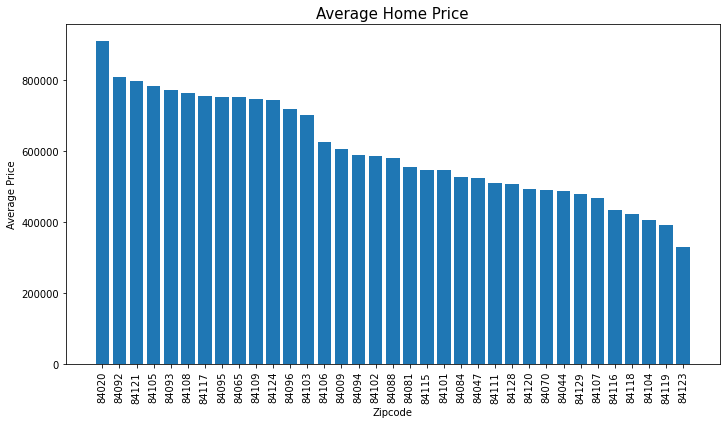

In [158]:
summary['zipcode'] = summary['zipcode'].astype(str).str.zfill(5)

x_axis = np.arange(len(summary))
tick_locations = [value for value in x_axis]
plt.figure(figsize=(10,6))
plt.bar(summary["zipcode"], summary["average_price"])
plt.xticks(tick_locations, summary["zipcode"], rotation='vertical')
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
plt.title("Average Home Price", fontsize = 15)
plt.xlabel("Zipcode")
plt.tight_layout()
plt.ylabel("Average Price")
plt.savefig('charts/Zip Average Home Price')
plt.show()

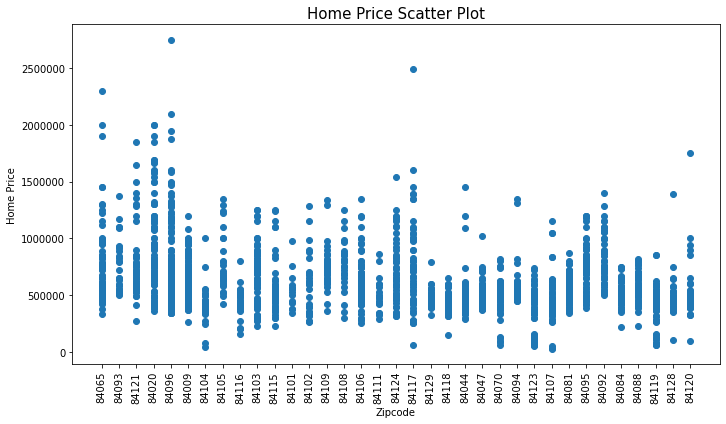

In [159]:
df['zipcode'] = df['zipcode'].astype(str).str.zfill(5)

x_axis = np.arange(len(summary))
tick_locations = [value for value in x_axis]
plt.figure(figsize=(10,6))
plt.scatter(df["zipcode"], df["price"])
plt.xticks(rotation='vertical')
plt.ticklabel_format(style='plain', useOffset=False, axis='y')
plt.title("Home Price Scatter Plot", fontsize = 15)
plt.xlabel("Zipcode")
plt.tight_layout()
plt.ylabel("Home Price")
plt.savefig('charts/Zip Home Price Scatter')
plt.show()

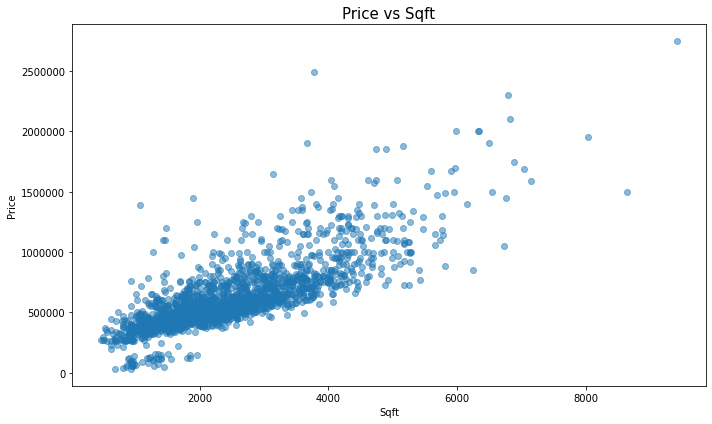

In [160]:
y_axis = df['price']
x_axis = df['sqft']

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x_axis, y_axis, alpha = 0.5)
ax.ticklabel_format(useOffset=False, style='plain', axis='y')
# ax.invert_yaxis()
ax.set_xlabel("Sqft")
ax.set_ylabel("Price")
ax.set_title("Price vs Sqft", fontsize = 15)
plt.tight_layout()
plt.savefig('charts/Price vs Sqft Scatterplot')
plt.show()

## Supervised Machine Learning

In [161]:
mod = sm.ols(formula="price ~ sqft + beds + baths + proptype", data = df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     872.9
Date:                Mon, 21 Nov 2022   Prob (F-statistic):               0.00
Time:                        21:41:49   Log-Likelihood:                -26554.
No. Observations:                1972   AIC:                         5.312e+04
Df Residuals:                    1967   BIC:                         5.315e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.024e+05   1.28e+04      7.974      0.0

In [162]:
average_price = df.groupby(["zipcode"]).mean().round(2)["price"]
# count = df.groupby(["zipcode"]).count()["price"]
average_sqft = df.groupby(["zipcode"]).mean().round(2)["sqft"]
cost_sqft = df.groupby(["zipcode"]).mean().round(2)["price_sqft"]
summary = pd.DataFrame({"average_price" : average_price,
                        # "count" : count,
                        "average_sqft" : average_sqft,
                        "cost_sqft" : cost_sqft})
summary = summary.reset_index()
summary = summary.sort_values(["average_price"], ascending=False)
summary

,zipcode,average_price,average_sqft,cost_sqft
1,84020,911048.78,3533.37,267.84
9,84092,808191.18,3565.67,232.87
30,84121,796197.69,2889.35,289.23
18,84105,782877.74,2400.26,332.07
10,84093,772603.04,2832.15,281.23
21,84108,764839.50,2194.54,367.20
26,84117,755798.23,2411.48,324.82
12,84095,752398.24,3203.45,248.94
4,84065,751719.03,3085.49,247.59
22,84109,746957.06,2650.37,295.66


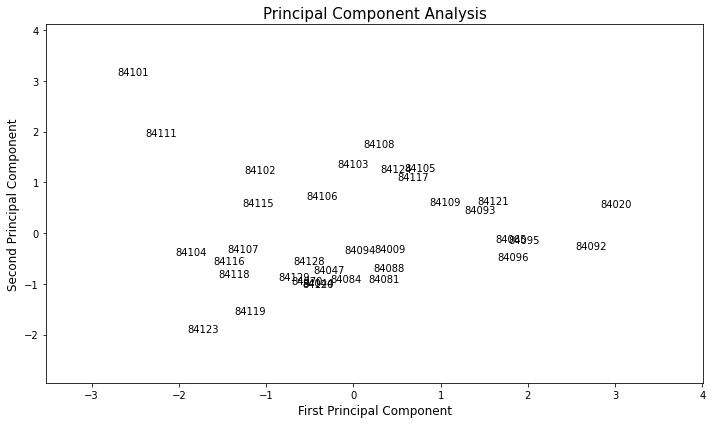

Explained Variance Ratios of the PCA: [0.59977592 0.39255202 0.00767206]


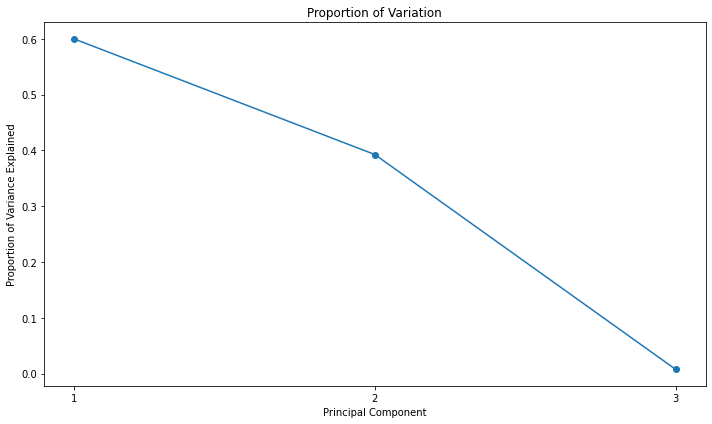

In [163]:
# Drops first state column
X = summary.drop(['zipcode'],axis=1).values
X = StandardScaler().fit_transform(X)

# PCA Model
pca_model = PCA(n_components=3)
X_PCA = pca_model.fit_transform(X)
df_plot = pd.DataFrame(X_PCA, columns=['PC1', 'PC2', 'PC3'])
df_plot.head()
fig,ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlim(X_PCA[:,0].min()-1,X_PCA[:,0].max()+1)
ax1.set_ylim(X_PCA[:,1].min()-1,X_PCA[:,1].max()+1)

# Recenters Data
for i,name in enumerate(summary['zipcode'].values):
    ax1.annotate(name, (X_PCA[i,0], X_PCA[i,1]), ha='center',fontsize=10)

ax1.set_xlabel('First Principal Component', fontsize = 12)
ax1.set_ylabel('Second Principal Component', fontsize = 12)
ax1.set_title('Principal Component Analysis', fontsize = 15)
plt.tight_layout()
plt.savefig('charts/PCA.png')
plt.show()

# Scree Plot
var_ratio = pca_model.explained_variance_ratio_
print('Explained Variance Ratios of the PCA:', var_ratio)

fig,ax1 = plt.subplots(figsize=(10, 6))
plt.plot([1,2,3], var_ratio, '-o')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.title('Proportion of Variation')
plt.xticks([1,2,3])
plt.tight_layout()
plt.savefig('charts/scree-plot.png')
plt.show()

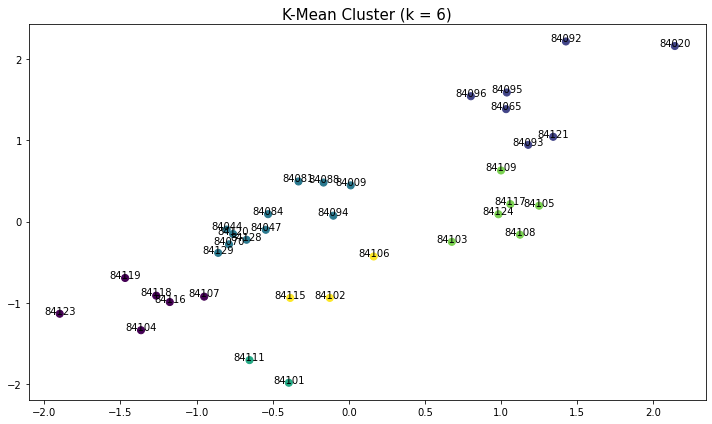

Cluster 1: ['84107', '84116', '84118', '84104', '84119', '84123']
Cluster 2: ['84020', '84092', '84121', '84093', '84095', '84065', '84096']
Cluster 3: ['84009', '84094', '84088', '84081', '84084', '84047', '84128', '84120', '84070', '84044', '84129']
Cluster 4: ['84101', '84111']
Cluster 5: ['84105', '84108', '84117', '84109', '84124', '84103']
Cluster 6: ['84106', '84102', '84115']


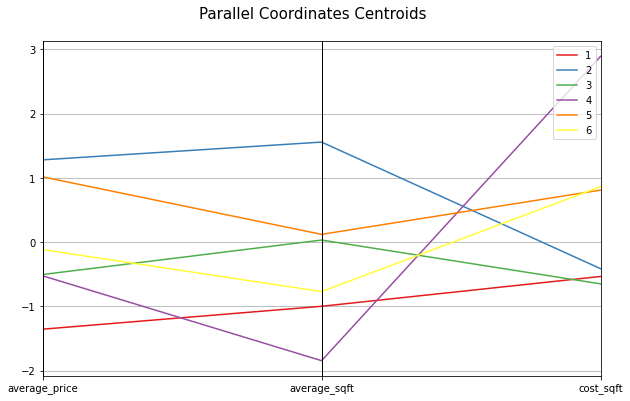

In [247]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
fig,ax1 = plt.subplots(figsize=(10, 6))

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50)

for i,name in enumerate(summary['zipcode'].values):
    ax1.annotate(name, (X[i,0], X[i,1]), ha='center',fontsize=10)

plt.title('K-Mean Cluster (k = 6)', fontsize = 15)
plt.tight_layout()
plt.savefig('charts/K-Mean.png')
plt.show()

df2 = summary['zipcode'].values
cluster1 = df2[kmeans.labels_==0].tolist()
cluster2 = df2[kmeans.labels_==1].tolist()
cluster3 = df2[kmeans.labels_==2].tolist()
cluster4 = df2[kmeans.labels_==3].tolist()
cluster5 = df2[kmeans.labels_==4].tolist()
cluster6 = df2[kmeans.labels_==5].tolist()
print('Cluster 1:', cluster1)
print('Cluster 2:', cluster2)
print('Cluster 3:', cluster3)
print('Cluster 4:', cluster4)
print('Cluster 5:', cluster5)
print('Cluster 6:', cluster6)

from pandas.plotting import parallel_coordinates

palette = sns.color_palette("Set1", 10)
X_df = summary.drop(['zipcode'],axis=1)
    
def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(10, 6))
    title = fig.suptitle("Parallel Coordinates Centroids", fontsize=15)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    parallel_coordinates(df, 'cluster', color=palette)

    # Stagger the axes
    ax=plt.gca() 
    plt.savefig('charts/Parallel-Centroids.png')

# Create a data frame containing our centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X_df.columns)
centroids['cluster'] = centroids.index + 1

display_parallel_coordinates_centroids(centroids, 6)

In [238]:
centroids

,average_price,average_sqft,cost_sqft,cluster
0,-0.503570,0.032468,-0.648808,1
1,1.015696,0.121069,0.809417,2
2,-1.353731,-0.997540,-0.533667,3
3,1.279922,1.556239,-0.412747,4
4,-0.522981,-1.843405,2.890358,5
5,-0.115339,-0.768395,0.863632,6


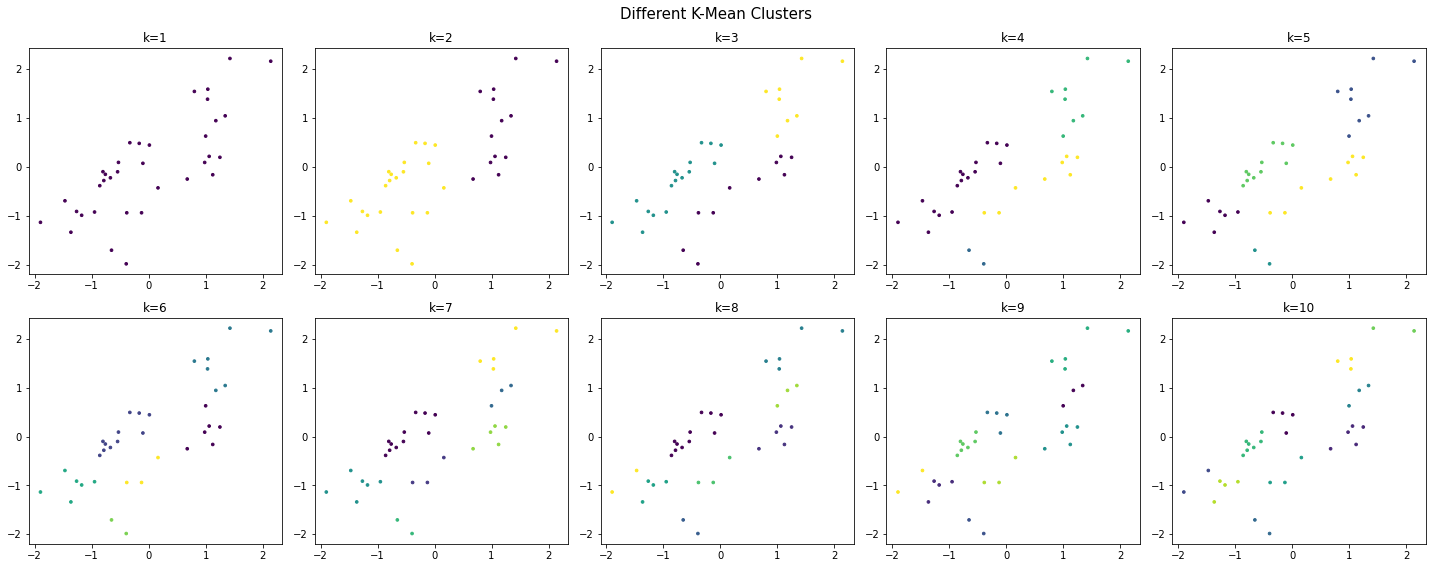

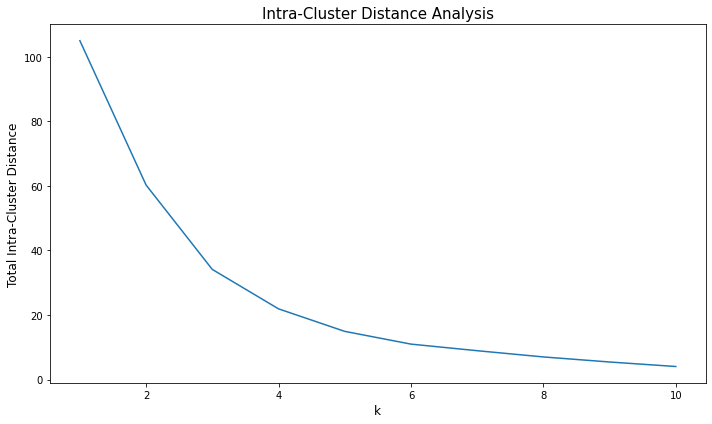

In [165]:
ks = range(1,11)
scores = []

fig, axs = plt.subplots(2,5, figsize=(20, 8))
fig.suptitle('Different K-Mean Clusters', fontsize = 15)

for k in ks:
    model = KMeans(n_clusters=k)
    y_pred = model.fit_predict(X)
    scores.append(-model.score(X))

    subplot = axs[int((k-1)/5)][(k-1)%5]
    subplot.scatter(X[:, 0], X[:, 1], c=y_pred,  marker="o", s=7);
    subplot.set_title("k="+str(k))
plt.tight_layout()
plt.savefig('charts/Different K-Means')

fig = plt.figure(figsize=(10, 6))
plt.plot(ks, scores)
plt.title('Intra-Cluster Distance Analysis', fontsize = 15)
plt.ylabel('Total Intra-Cluster Distance', fontsize = 12)
plt.xlabel('k', fontsize = 12)
plt.tight_layout()
plt.savefig('charts/Intra-Cluster-Distance.png')
plt.show()

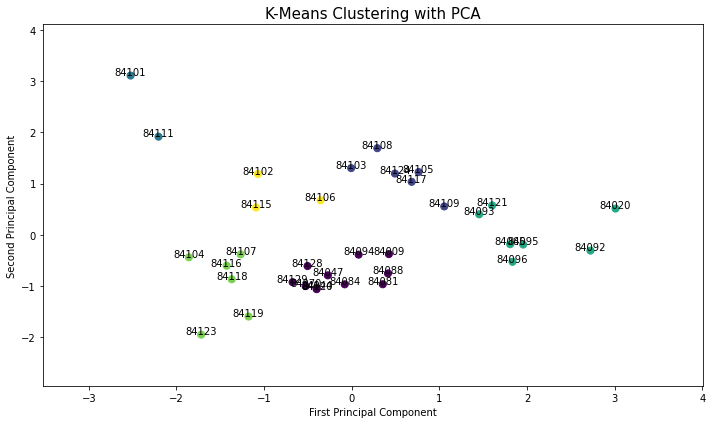

In [179]:
fig,ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlim(X_PCA[:,0].min()-1,X_PCA[:,0].max()+1)
ax1.set_ylim(X_PCA[:,1].min()-1,X_PCA[:,1].max()+1)

plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y_kmeans, s=50)

for i,name in enumerate(summary['zipcode'].values):
    ax1.annotate(name, (X_PCA[i,0], X_PCA[i,1]), ha='center',fontsize=10)

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
plt.title('K-Means Clustering with PCA', fontsize = 15)
plt.tight_layout()
plt.savefig('charts/K-Mean-PCA.png')
plt.show()

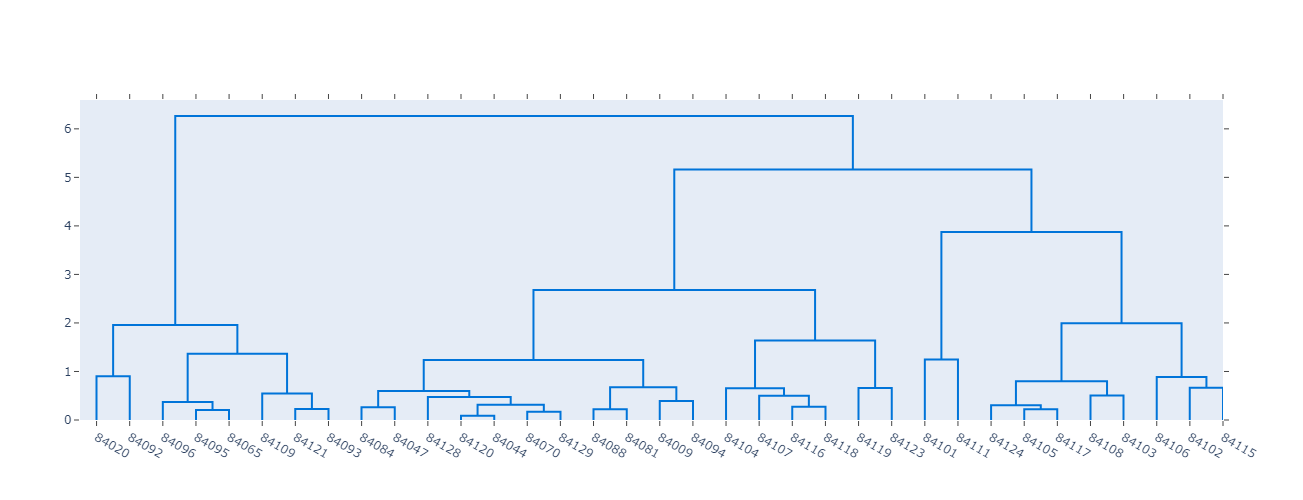

In [177]:
# Create the dendrogram
fig = ff.create_dendrogram(X_PCA, color_threshold=0, labels=summary['zipcode'].values)
fig.update_layout(width=800, height=500)
fig.write_image("charts/dendogram.png")
fig.show()

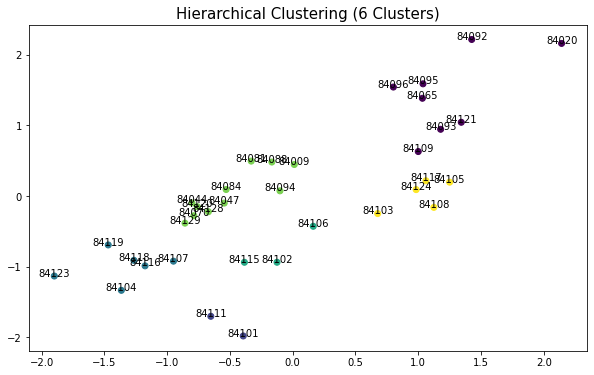

Cluster 1: ['84020', '84092', '84121', '84093', '84095', '84065', '84109', '84096']
Cluster 2: ['84101', '84111']
Cluster 3: ['84107', '84116', '84118', '84104', '84119', '84123']
Cluster 4: ['84106', '84102', '84115']
Cluster 5: ['84009', '84094', '84088', '84081', '84084', '84047', '84128', '84120', '84070', '84044', '84129']
Cluster 6: ['84105', '84108', '84117', '84124', '84103']


In [249]:
fig,ax1 = plt.subplots(figsize=(10, 6))
agg_cluster_model = AgglomerativeClustering(linkage="complete", affinity='euclidean', n_clusters=6)
y_pred = agg_cluster_model.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred,  marker="o")
for i,name in enumerate(summary['zipcode'].values):
    ax1.annotate(name, (X[i,0], X[i,1]), ha='center',fontsize=10)
plt.title('Hierarchical Clustering (6 Clusters)', fontsize = 15)
plt.savefig('charts/Hierarchical.png')
plt.show()

cluster1 = df2[agg_cluster_model.labels_==0].tolist()
cluster2 = df2[agg_cluster_model.labels_==1].tolist()
cluster3 = df2[agg_cluster_model.labels_==2].tolist()
cluster4 = df2[agg_cluster_model.labels_==3].tolist()
cluster5 = df2[agg_cluster_model.labels_==4].tolist()
cluster6 = df2[agg_cluster_model.labels_==5].tolist()
print('Cluster 1:', cluster1)
print('Cluster 2:', cluster2)
print('Cluster 3:', cluster3)
print('Cluster 4:', cluster4)
print('Cluster 5:', cluster5)
print('Cluster 6:', cluster6)

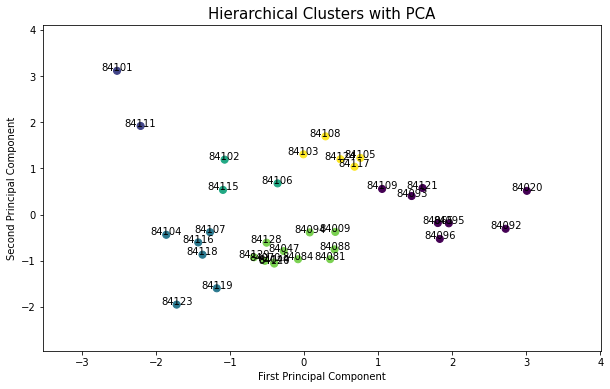

In [170]:
fig,ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlim(X_PCA[:,0].min()-1,X_PCA[:,0].max()+1)
ax1.set_ylim(X_PCA[:,1].min()-1,X_PCA[:,1].max()+1)

plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y_pred, s=50)

for i,name in enumerate(summary['zipcode'].values):
    ax1.annotate(name, (X_PCA[i,0], X_PCA[i,1]), ha='center',fontsize=10)

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
plt.title('Hierarchical Clusters with PCA', fontsize = 15)
plt.savefig('charts/Hierarchical-PCA.png')
plt.show()